In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image

# 1. hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 50
latent_dim = 512

In [3]:
# 2. load data
class TexturesDataset(torch.utils.data.Dataset):
    def __init__(self, split='train'):
        raw_dataset = load_dataset("dream-textures/textures-color-normal-1k", split=split)

        # Only keep samples where both images are RGB (not grayscale)
        self.valid_samples = []
        i = 0
        while i < 465: # id 465 is metadata: avoid
            color = raw_dataset[i]['color']
            normal = raw_dataset[i]['normal']

            # if we want to keep grayscale we could convert to RGB
            #if isinstance(color, Image.Image) and isinstance(normal, Image.Image):
            #   color = color.convert('RGB')
            #   normal = normal.convert('RGB')
            #   raw_dataset[i]['color'] = color
            #   raw_dataset[i]['normal'] = normal
            #   self.valid_samples.append(raw_dataset[i])

            if (
                isinstance(color, Image.Image) and color.mode == 'RGB' and
                isinstance(normal, Image.Image) and normal.mode == 'RGB'
              ):
                self.valid_samples.append(raw_dataset[i])
            else:
              print(f"Skipping sample {i}: grayscale or invalid mode. Color: {color.mode}, Normal: {normal.mode}")
            i += 1

        i += 1
        while i < len(raw_dataset):
            color = raw_dataset[i]['color']
            normal = raw_dataset[i]['normal']
            if (
                isinstance(color, Image.Image) and color.mode == 'RGB' and
                isinstance(normal, Image.Image) and normal.mode == 'RGB'
              ):
                self.valid_samples.append(raw_dataset[i])
            else:
              print(f"Skipping sample {i}: grayscale or invalid mode. Color: {color.mode}, Normal: {normal.mode}")
            i += 1

        print(f"Loaded {len(self.valid_samples)} valid RGB samples out of {len(raw_dataset)}.")

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    # for DataLoader
    def __len__(self):
        return len(self.valid_samples)

    # for DataLoader
    def __getitem__(self, idx):
        sample = self.valid_samples[idx]
        color_tensor = self.transform(sample['color'])
        normal_tensor = self.transform(sample['normal'])
        stacked_tensor = torch.cat((color_tensor, normal_tensor), dim=0)  # Shape: [6, 512, 512]
        return stacked_tensor

# load training data
train_dataset = TexturesDataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

(…)-00000-of-00001-7d3033d434a1d73a.parquet:   0%|          | 0.00/111M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1426 [00:00<?, ? examples/s]

Skipping sample 35: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 155: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 300: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 366: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 495: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 713: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 728: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 734: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 791: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 805: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 847: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 863: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 879: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 1056: grayscale or invalid mode. Color: L, Normal: RGB
Skipping sample 1090

In [5]:
# use DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# 3. autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1),   # -> (64, 256, 256)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # -> (128, 128, 128)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # -> (256, 64, 64)
            nn.ReLU(),
            #nn.Conv2d(256, 512, 4, stride=2, padding=1), # -> (512, 32, 32)
            #nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 64 * 64, latent_dim) # use product of last used conv2d layer
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 64 * 64), #nn.Linear(latent_dim, 512 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (256, 64, 64)),#nn.Unflatten(1, (512, 32, 32)),
            #nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # -> (256, 64, 64)
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # -> (128, 128, 128)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # -> (64, 256, 256)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 6, 4, stride=2, padding=1),
            nn.Sigmoid()  # For pixel values in [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [ ]:
# 3. autoencoder model + residual block
# This works by uncommenting lines and deleting those in front
# With a 64x64 approach it runs out of memory in A100.
# Proposal: just tune simple ConvAutoencoder Architecture
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.block(x))


class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),   # -> (64, 256, 256)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> (128, 128, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# -> (256, 64, 64)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            ResidualBlock(256),
            #nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),# -> (512, 32, 32)
            #nn.BatchNorm2d(512),
            #nn.ReLU(inplace=True),
            #ResidualBlock(512),
            #nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),# -> (512, 16, 16)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 64 * 64, latent_dim),#nn.Linear(512 * 16 * 16, latent_dim),
            nn.ReLU(inplace=True),
            nn.Linear(latent_dim, 256 * 64 * 64),#nn.Linear(latent_dim, 512 * 16 * 16),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 64, 64))#nn.Unflatten(1, (512, 16, 16))
        )

        # Decoder
        self.decoder = nn.Sequential(
            #ResidualBlock(512),
            #nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # -> (256, 32, 32)
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            ResidualBlock(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> (128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 6, kernel_size=4, stride=2, padding=1),#nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> (32, 256, 256)
            #nn.ReLU(inplace=True),
            #nn.ConvTranspose2d(32, 6, kernel_size=4, stride=2, padding=1),    # -> (6, 512, 512)
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.bottleneck(z)
        out = self.decoder(z)
        return out

In [ ]:
# check output dimensions
nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)(torch.rand(32,256,64,64)).shape
nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)(torch.rand(32,128,128,128)).shape
nn.ConvTranspose2d(64, 6, kernel_size=4, stride=2, padding=1)(torch.rand(32,64,256,256)).shape

torch.Size([32, 6, 512, 512])

In [7]:
# 4. training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss() # nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# 5. training loop
# This was trained on Google Colab using L4 or A100 to speed computations up
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/50], Loss: 0.0324
Epoch [2/50], Loss: 0.0178
Epoch [3/50], Loss: 0.0116
Epoch [4/50], Loss: 0.0099
Epoch [5/50], Loss: 0.0096
Epoch [6/50], Loss: 0.0093
Epoch [7/50], Loss: 0.0088
Epoch [8/50], Loss: 0.0085
Epoch [9/50], Loss: 0.0082
Epoch [10/50], Loss: 0.0081
Epoch [11/50], Loss: 0.0078
Epoch [12/50], Loss: 0.0073
Epoch [13/50], Loss: 0.0072
Epoch [14/50], Loss: 0.0070
Epoch [15/50], Loss: 0.0069
Epoch [16/50], Loss: 0.0068
Epoch [17/50], Loss: 0.0067
Epoch [18/50], Loss: 0.0066
Epoch [19/50], Loss: 0.0070
Epoch [20/50], Loss: 0.0066
Epoch [21/50], Loss: 0.0063
Epoch [22/50], Loss: 0.0064
Epoch [23/50], Loss: 0.0061
Epoch [24/50], Loss: 0.0059
Epoch [25/50], Loss: 0.0057
Epoch [26/50], Loss: 0.0059
Epoch [27/50], Loss: 0.0057
Epoch [28/50], Loss: 0.0055
Epoch [29/50], Loss: 0.0055
Epoch [30/50], Loss: 0.0054
Epoch [31/50], Loss: 0.0055
Epoch [32/50], Loss: 0.0056
Epoch [33/50], Loss: 0.0054
Epoch [34/50], Loss: 0.0052
Epoch [35/50], Loss: 0.0051
Epoch [36/50], Loss: 0.0050
E

In [9]:
# 6. visualize original vs reconstructed images
def show_reconstructions(model, n=5):
    model.eval()
    data = next(iter(train_loader))
    data = data[:n].to(device)
    with torch.no_grad():
        reconstructed = model(data)

    data = data.cpu()
    reconstructed = reconstructed.cpu()
    fig, axs = plt.subplots(4, n, figsize=(n * 2, 6))
    for i in range(n):
        # Original Color Image
        axs[0, i].imshow(data[i, :3].permute(1, 2, 0))
        axs[0, i].axis('off')
        # Original Normal Map
        axs[1, i].imshow(data[i, 3:].permute(1, 2, 0))
        axs[1, i].axis('off')
        # Reconstructed Color Map
        axs[2, i].imshow(reconstructed[i, :3].permute(1, 2, 0))
        axs[2, i].axis('off')
        # Reconstructed Normal Map
        axs[3, i].imshow(reconstructed[i, 3:].permute(1, 2, 0))
        axs[3, i].axis('off')
    axs[0, 0].set_title('Original Color')
    axs[1, 0].set_title('Original Normal')
    axs[2, 0].set_title('Reconstructed Color Map')
    axs[3, 0].set_title('Reconstructed Normal Map')
    plt.tight_layout()
    plt.show()

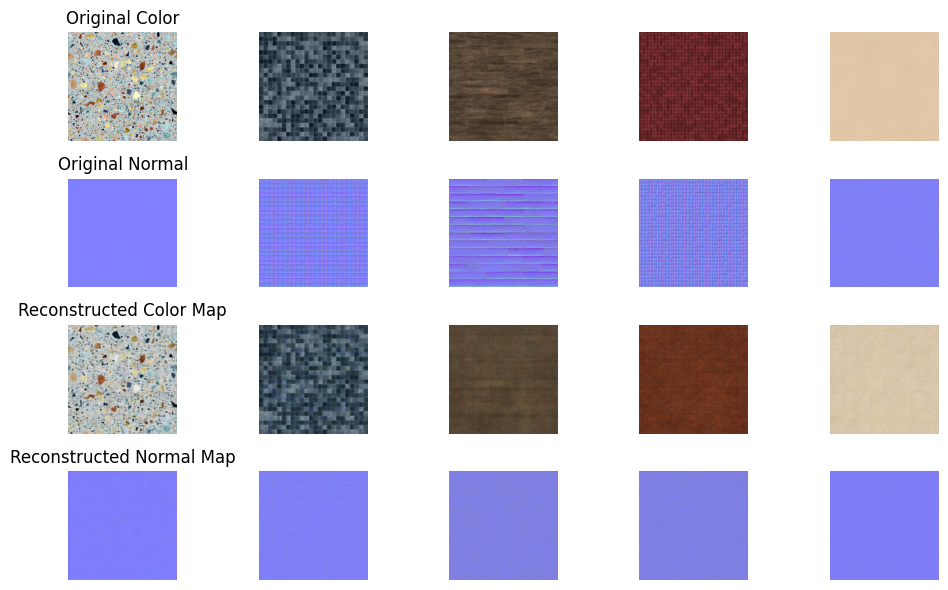

In [19]:
# simple autoenconder model
show_reconstructions(model)